In [1]:
!mkdir -p /root/.config/kaggle/
!cp /content/drive/MyDrive/kaggle.json /root/.config/kaggle/kaggle.json
!chmod 600 /root/.config/kaggle/kaggle.json

In [2]:
import kaggle

kaggle.api.authenticate()

kaggle.api.dataset_download_files('preetviradiya/brian-tumor-dataset', path="/content/drive/MyDrive/ML/Brain Tumor Classification", unzip=True)

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset


In [3]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [4]:
# Enable mixed precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [5]:
# Set up constants
BATCH_SIZE = 64
IMAGE_SIZE = 150
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 1)

In [6]:
# Set up data generators
data_gen = ImageDataGenerator(rescale=1./255,
                              validation_split = 0.2)

In [7]:
img_dir = '/content/drive/MyDrive/ML/Brain Tumor Classification/Brain Tumor Data Set/Brain Tumor Data Set'

In [8]:
# Create train and validation generators
train_gen = data_gen.flow_from_directory(img_dir,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "grayscale",
                                        shuffle=True,
                                        class_mode = "binary",
                                        subset = "training")

val_gen = data_gen.flow_from_directory(img_dir,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size = BATCH_SIZE,
                                        color_mode= "grayscale",
                                        shuffle=False,
                                        class_mode = "binary",
                                        subset = "validation")

Found 3681 images belonging to 2 classes.
Found 919 images belonging to 2 classes.


In [9]:
# Get class labels
labels = train_gen.class_indices
classes = list(labels.keys())
print("Classes:", classes)

Classes: ['Brain Tumor', 'Healthy']


Sample training images:


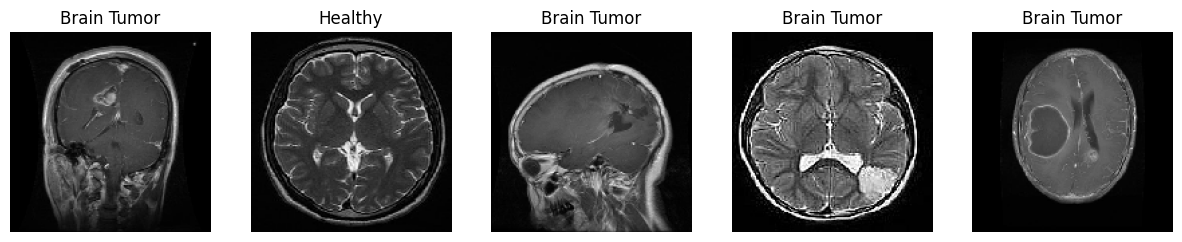

In [10]:
def plot_sample_images(generator, num_images=5):
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        batch = next(generator)
        image = batch[0][0]
        plt.imshow(image.reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
        plt.title(classes[int(batch[1][0])])
        plt.axis('off')
    plt.show()

print("Sample training images:")
plot_sample_images(train_gen)

In [11]:
# Create the model
model = keras.Sequential([
    keras.layers.InputLayer(shape=INPUT_SHAPE),
    keras.layers.Conv2D(16, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(32, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 41472)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      21,234,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,239,489 (81.02 MB)

 Trainable params: 21,239,489 (81.02 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model
history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    steps_per_epoch=3681//64,
    validation_steps=919//64
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 26s 340ms/step - accuracy: 0.6177 - loss: 2.2489 - precision: 0.6339 - recall: 0.3475 - val_accuracy: 0.8158 - val_loss: 0.4334 - val_precision: 0.7495 - val_recall: 0.8731
Epoch 2/10
 1/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8750 - loss: 0.3902 - precision: 0.8000 - recall: 0.8696

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.8750 - loss: 0.3902 - precision: 0.8000 - recall: 0.8696 - val_accuracy: 0.7826 - val_loss: 0.3697 - val_precision: 1.0000 - val_recall: 0.7826
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 242ms/step - accuracy: 0.8813 - loss: 0.2987 - precision: 0.8876 - recall: 0.8557 - val_accuracy: 0.9286 - val_loss: 0.1939 - val_precision: 0.9412 - val_recall: 0.8934
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9531 - loss: 0.1385 - precision: 1.0000 - recall: 0.8636 - val_accuracy: 0.8261 - val_loss: 0.3378 - val_precision: 1.0000 - val_recall: 0.8261
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 243ms/step - accuracy: 0.9433 - loss: 0.1527 - precision: 0.9463 - recall: 0.9263 - val_accuracy: 0.9732 - val_loss: 0.0812 - val_precision: 0.9672 - val_recall: 0.9721
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9375 - loss: 0.1455 - precision: 0.9643 - recall: 0.9000 - val_accuracy: 1.0000 - val_loss: 0.0690 - val_pre

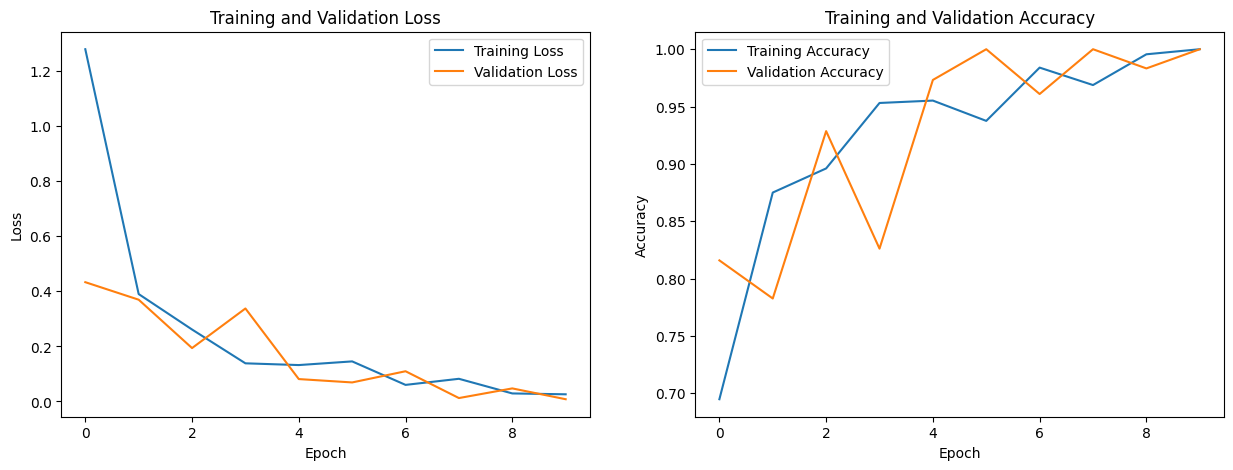

In [15]:
# Plot training history
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

plot_training_history(history)

In [16]:
# Evaluate the model
test_loss, test_acc, test_precision, test_recall = model.evaluate(val_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9729 - loss: 0.0746 - precision: 0.4976 - recall: 0.5619
Test Accuracy: 0.9848
Test Precision: 0.9697
Test Recall: 0.9976


In [17]:
# Calculate F1-score
f1_score = 2 * (test_precision * test_recall) / (test_precision + test_recall)
print(f"F1-score: {f1_score:.4f}")

F1-score: 0.9835


In [18]:
# Generate predictions for confusion matrix and ROC curve
y_pred = model.predict(val_gen)
y_true = val_gen.classes

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step


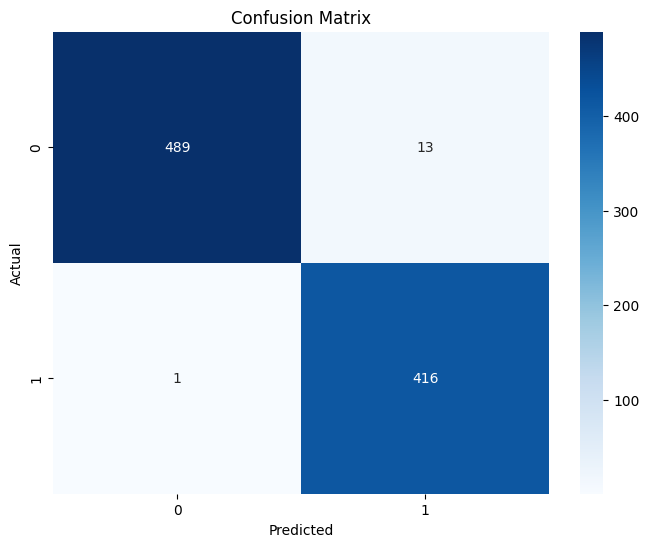

In [19]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred.round())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

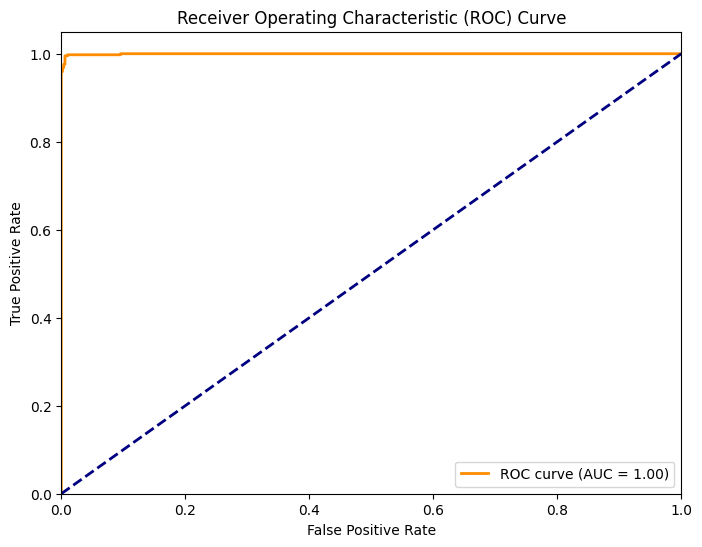

In [20]:
# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [21]:
# Save the model
model.save('/content/drive/MyDrive/ML/Brain Tumor Classification/brain_tumor_model.keras')
print("Model saved as 'brain_tumor_model.keras'")

Model saved as 'brain_tumor_model.keras'
